In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.core import Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Bidirectional
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Data prepartation

In this study, we will use a set of reviews of women's clothing. It contains a text review and a numerical rating from 1 to 5.

In [2]:
clothes_reviews = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col='Unnamed: 0')
clothes_reviews.head(2)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


There are 23.5k total reviews in the dataset.

In [3]:
clothes_reviews.shape

(23486, 10)

Let's create a more convenient dataframe with only text feedback (predictor) and a numeric score (target)

In [4]:
data = pd.DataFrame(data=clothes_reviews['Review Text']).rename(columns={'Review Text': 'review'})
data['sentiment'] = clothes_reviews['Rating']  # np.where(clothes_reviews['Rating'] > 3, 'Positive', 'Negative')
data.sentiment.value_counts()

sentiment
5    13131
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64

Let's remove any missing values.

In [5]:
data.isnull().values.any()
data = data.dropna()

So we're down to 22.5k values.

In [6]:
data.shape

(22641, 2)

Let's graph the classes to visually evaluate them and test our intuition.

<Axes: xlabel='sentiment', ylabel='count'>

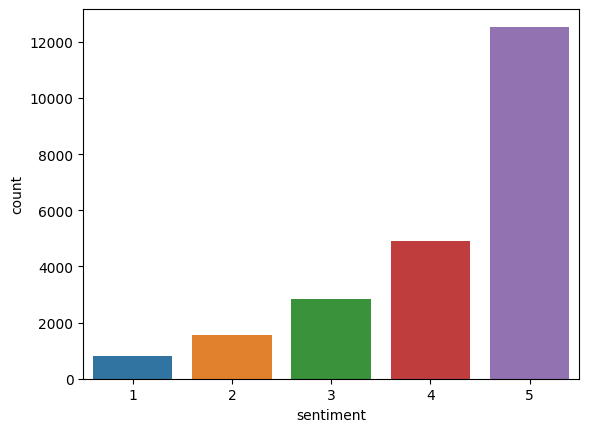

In [7]:
import seaborn as sns
sns.countplot(x='sentiment', data=data)

While reviews should not contain html tags, links, or similar specific text, we will include a procedure of getting rid of them as part of the pre-processing pipeline. This will make the code more versatile and reusable in case we need to analyze another dataset, such as comments on a forum or imageboard.

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
    return TAG_RE.sub('', text)

def preprocess_text(text):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    '''
    Takes text as input and cleaning it up by deleteng all words that are less than 2 characters and
    contains only letters. Returns text in all lower case.
    '''
    sentence = text.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space.
    # Hence, we are left with single character "s" that we are removing here.
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Remove multiple spaces
    # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.
    sentence = re.sub(r'\s+', ' ', sentence)
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

Now let's apply preprocessing to our dataset.

In [9]:
X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

One-hot encoding the target variable.

In [10]:
y = data['sentiment']
s = np.array(y)
y = np.zeros((s.size, s.max()))
y[np.arange(s.size), s-1] = 1
y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

Let's split the predictor and target into a training and a testing part.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Now let's perform the tokenization of the predictor. Since in X the text has already been prepared in advance, tokenization will only perform word splitting.

In [12]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [13]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

12137

On average, one review has 181 words. Let's keep this number for future use.

In [14]:
pd.Series(X).apply(lambda x: len(x)).mean()

181.6198489466013

Let's set the maximum length of a review to 200 characters and "align" all reviews to this parameter. Those with more than 200 words will be trimmed, and those with not enough words will have empty spaces added.

In [15]:
maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### Pretrained Model: Global Vectors for Word Representation (GloVe)

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
More info on GloVe: https://nlp.stanford.edu/projects/glove/

We will use model trained on 6 billions tokens with 100 dimentional word vector.

The *glove.6B.100d.txt* is available at this link: 
https://drive.google.com/file/d/1pSuzGC8Dwpq_xj9cZfTT0zEzwn5SAHi6/view?usp=drive_link

In [16]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Let's make embedding vector for each unique word in all reviews.

In [17]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
embedding_matrix.shape

(12137, 100)

Before we start working with neural networks, let's write a function to plot graphs from the model history

In [19]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

#### Straightforward Neural Network. (Or the Simple one)

In [20]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(5, activation='sigmoid'))

In [21]:
snn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1213700   
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 5)                 100005    
                                                                 
Total params: 1,313,705
Trainable params: 100,005
Non-trainable params: 1,213,700
_________________________________________________________________
None


In [22]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
 30/114 [======>.......................] - ETA: 0s - loss: 1.2853 - acc: 0.5122

114/114 [==============================] - 1s 8ms/step - loss: 1.1824 - acc: 0.5434 - val_loss: 1.1499 - val_acc: 0.5471
Epoch 2/6
114/114 [==============================] - 1s 7ms/step - loss: 0.9854 - acc: 0.6051 - val_loss: 1.1441 - val_acc: 0.5531
Epoch 3/6
114/114 [==============================] - 1s 6ms/step - loss: 0.9005 - acc: 0.6458 - val_loss: 1.1383 - val_acc: 0.5504
Epoch 4/6
114/114 [==============================] - 1s 7ms/step - loss: 0.8416 - acc: 0.6755 - val_loss: 1.1601 - val_acc: 0.5498
Epoch 5/6
114/114 [==============================] - 1s 6ms/step - loss: 0.7983 - acc: 0.6937 - val_loss: 1.1729 - val_acc: 0.5460
Epoch 6/6
114/114 [==============================] - 1s 7ms/step - loss: 0.7627 - acc: 0.7103 - val_loss: 1.2033 - val_acc: 0.5454


In [23]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

 38/142 [=======>......................] - ETA: 0s - loss: 1.2028 - acc: 0.5543

142/142 [==============================] - 0s 1ms/step - loss: 1.1524 - acc: 0.5611


It can be seen that the accuracy of the model on the training data and the test data is markedly different. This means that there is an overfitting problem.

In [24]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.1524430513381958
Test Accuracy: 0.5610510110855103


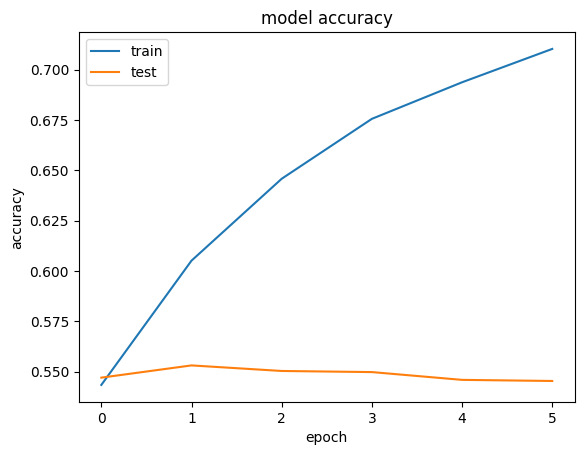

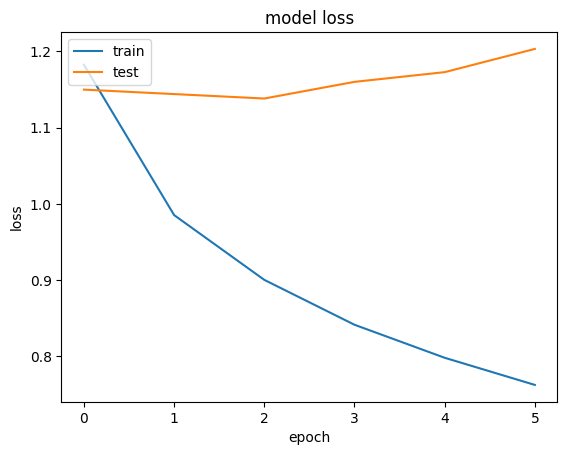

In [25]:
plot_history(snn_model_history)

#### Convolutional Neural Network

In [26]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(5, activation='sigmoid'))

In [27]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          1213700   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,278,473
Trainable params: 64,773
Non-trainable params: 1,213,700
_________________________________________________________________
None


In [28]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


114/114 [==============================] - 6s 47ms/step - loss: 1.1861 - acc: 0.5457 - val_loss: 1.0920 - val_acc: 0.5672
Epoch 2/6
114/114 [==============================] - 5s 43ms/step - loss: 0.9483 - acc: 0.6241 - val_loss: 1.0252 - val_acc: 0.5887
Epoch 3/6
114/114 [==============================] - 5s 44ms/step - loss: 0.8413 - acc: 0.6722 - val_loss: 1.0067 - val_acc: 0.5810
Epoch 4/6
114/114 [==============================] - 5s 44ms/step - loss: 0.7573 - acc: 0.7147 - val_loss: 1.0109 - val_acc: 0.5926
Epoch 5/6
114/114 [==============================] - 6s 48ms/step - loss: 0.6892 - acc: 0.7493 - val_loss: 0.9871 - val_acc: 0.5940
Epoch 6/6
114/114 [==============================] - 5s 46ms/step - loss: 0.6116 - acc: 0.7922 - val_loss: 0.9995 - val_acc: 0.5970


In [29]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

 15/142 [==>...........................] - ETA: 0s - loss: 0.9710 - acc: 0.6062

142/142 [==============================] - 1s 4ms/step - loss: 0.9659 - acc: 0.6127


Accuracy is better, but there is still an overfitting problem present, judging by the difference in test and training accuracy.

In [30]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9658884406089783
Test Accuracy: 0.6127180457115173


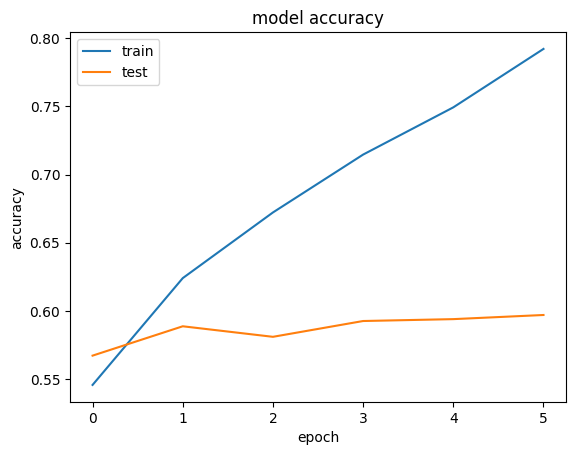

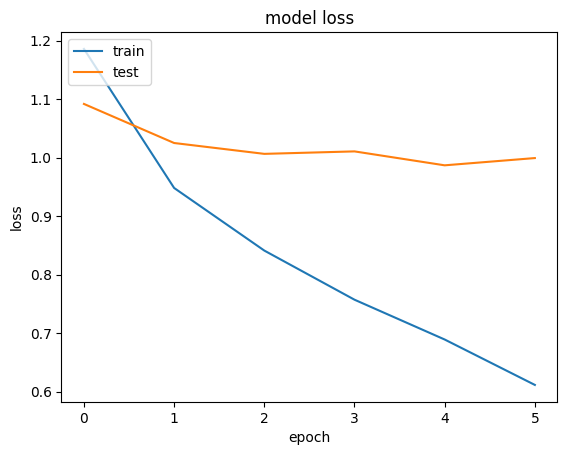

In [31]:
plot_history(cnn_model_history)

#### Long Short-Term Memory Neural Network (RNN)

In [32]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(128)))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(5, activation='sigmoid'))

In [33]:
optimizer = Adam(learning_rate=0.01)
lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          1213700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,449,481
Trainable params: 235,781
Non-trainable params: 1,213,700
_________________________________________________________________
None


In [34]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


114/114 [==============================] - 65s 537ms/step - loss: 1.1400 - acc: 0.5528 - val_loss: 1.0521 - val_acc: 0.5708
Epoch 2/6
114/114 [==============================] - 63s 557ms/step - loss: 0.9733 - acc: 0.5960 - val_loss: 0.9586 - val_acc: 0.6045
Epoch 3/6
114/114 [==============================] - 60s 527ms/step - loss: 0.9326 - acc: 0.6096 - val_loss: 0.9456 - val_acc: 0.6122
Epoch 4/6
114/114 [==============================] - 62s 548ms/step - loss: 0.9474 - acc: 0.6094 - val_loss: 0.9407 - val_acc: 0.6059
Epoch 5/6
114/114 [==============================] - 68s 599ms/step - loss: 0.8673 - acc: 0.6379 - val_loss: 0.9154 - val_acc: 0.6150
Epoch 6/6
114/114 [==============================] - 70s 611ms/step - loss: 0.8266 - acc: 0.6542 - val_loss: 0.9242 - val_acc: 0.6094


In [35]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

  1/142 [..............................] - ETA: 10s - loss: 1.2552 - acc: 0.5000

142/142 [==============================] - 6s 44ms/step - loss: 0.9034 - acc: 0.6306


As we can see, the model has the highest accuracy among all presented. Moreover, the difference between test and training accuracy is insignificant, which means that the model is not strongly overfitting. In addition, we added Dropout layer to reduce overfitting, which could also contribute.

In [36]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9034373164176941
Test Accuracy: 0.6306027770042419


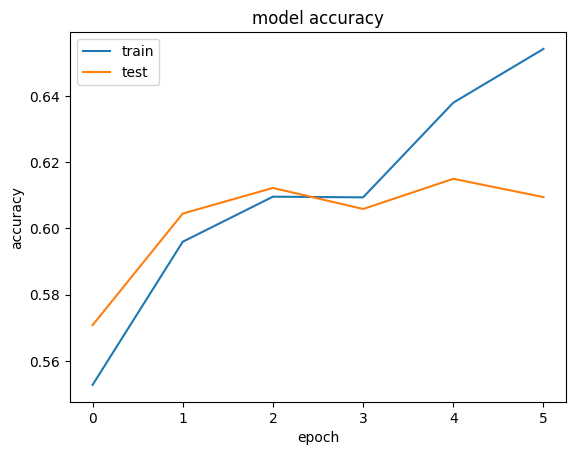

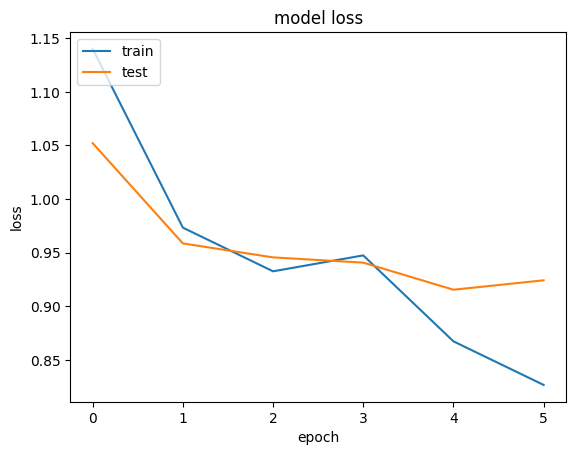

In [37]:
plot_history(lstm_model_history)

Let's save the most successful LSTM model to a file, as it took some time to train, and in future use it will speed up our work.

In [38]:
lstm_model.save(f"./lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

#### Conclusion

To summarize, LSTM architecture is really well suited for training on continuous data such as texts, music, etc. However, the training process takes much longer time compared to the simple architecture, which in a sense makes the selection of hyperparameters more difficult due to the reduced number of model iterations per unit time. In conclusion, the quality of the model, in addition to the architecture, depends on the selected hyperparameters and data preparation, and in our case also on the selected pretrained model.